Short script to look at price data pickle.

In [ ]:
import pandas as pd

file_path = 'data/raw/all_tickers_historical_data.pkl'

try:
    data = pd.read_pickle(file_path)
    
    # --- PART 1: Inspecting the Nested 'QCOM' Dictionary ---
    print(f"--- 1. Deep Dive into 'QCOM' ---")
    
    if 'QCOM' in data:
        qcom_val = data['QCOM']
        
        # We know qcom_val is a dict, so let's look at its keys
        if isinstance(qcom_val, dict):
            print(f"Keys found inside 'QCOM': {list(qcom_val.keys())}\n")
            
            for sub_key, sub_val in qcom_val.items():
                print(f"Key: ['{sub_key}']")
                print(f"   Type: {type(sub_val)}")
                
                # If it's a DataFrame, show columns and first row
                if isinstance(sub_val, pd.DataFrame):
                    print(f"   Shape: {sub_val.shape}")
                    print(f"   Columns: {list(sub_val.columns)}")
                    print(sub_val.head(2).to_string()) # Print first 2 rows clearly
                
                # If it's a simple value or list, print it directly
                else:
                    print(f"   Value: {sub_val}")
                print("-" * 30)
    else:
        print("Key 'QCOM' not found (weird, since we saw it earlier).")

    # --- PART 2: Searching for S&P 500 Keys ---
    print(f"\n--- 2. Searching for S&P 500 Keys ---")
    
    # Common variations for the S&P 500
    search_terms = ['sp500', 's&p', 'spx', 'gspc', 'spy', 'index']
    found_keys = []

    # Case-insensitive search through all top-level keys
    for key in data.keys():
        key_str = str(key).lower()
        if any(term in key_str for term in search_terms):
            found_keys.append(key)

    if found_keys:
        print(f"Found {len(found_keys)} potential matches:")
        print(found_keys)
    else:
        print("No keys found matching typical S&P 500 terms (sp500, s&p, gspc, spy).")

except Exception as e:
    print(f"Error: {e}")

Data exploration for the new multiclass labels.

Configuration: Symmetric Thresholds Loaded
Loading data/processed/ml_dataset_with_multiclass_labels.csv...

--- Categorical Label Distributions (Symmetric) ---


C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3526314244.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3526314244.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3526314244.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\User

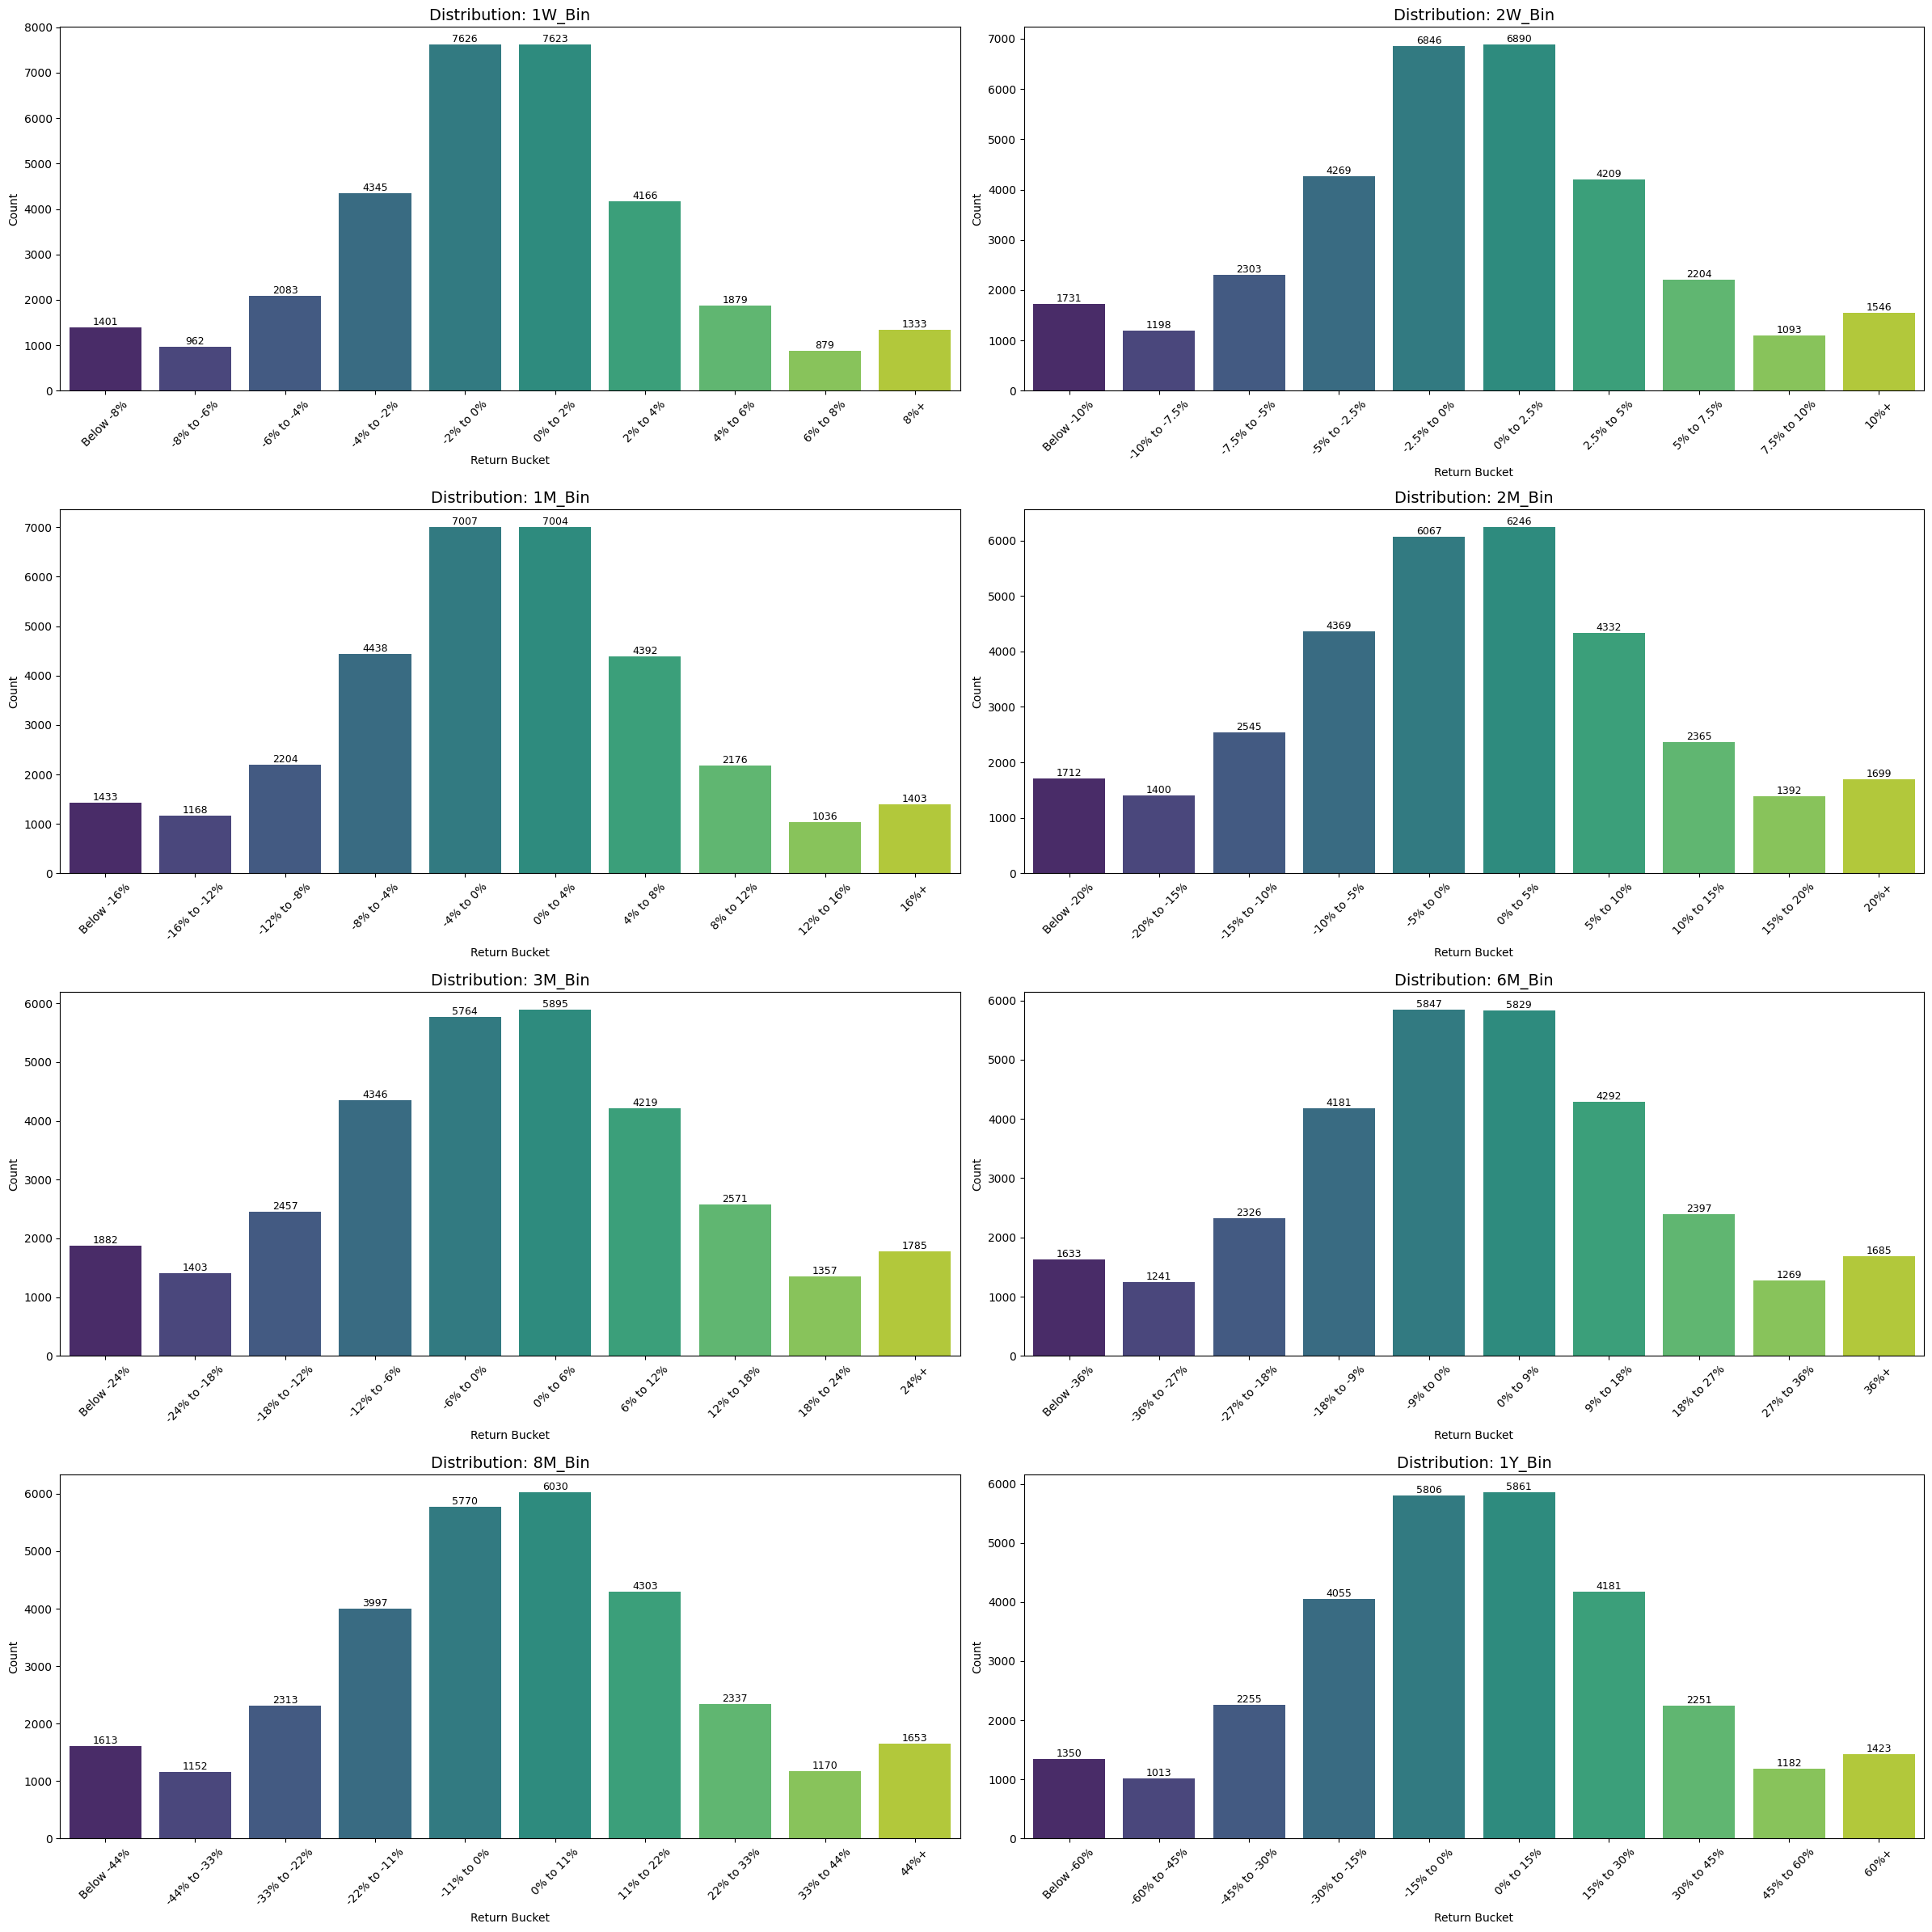

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from IPython.display import display

# ================= CONFIGURATION =================
FILE_PATH = 'data/processed/ml_dataset_with_multiclass_labels.csv'
CLIP_PCT = 0.0005 

# Base POSITIVE thresholds (Must match the generation script)
_BASE_THRESHOLDS = {
    '1W': [0, 2, 4, 6, 8],
    '2W': [0, 2.5, 5, 7.5, 10],
    '1M': [0, 4, 8, 12, 16],
    '2M': [0, 5, 10, 15, 20],
    '3M': [0, 6, 12, 18, 24],
    '6M': [0, 9, 18, 27, 36],
    '8M': [0, 11, 22, 33, 44],
    '1Y': [0, 15, 30, 45, 60]
}

# Generate Full Symmetric Thresholds dynamically
LABEL_THRESHOLDS = {}
for p, vals in _BASE_THRESHOLDS.items():
    negatives = sorted([-x for x in vals if x != 0])
    full_list = negatives + sorted(vals)
    LABEL_THRESHOLDS[p] = full_list

print("Configuration: Symmetric Thresholds Loaded")
# =================================================

def generate_label_order(period_name):
    """
    Reconstructs the expected string labels for a given period 
    to ensure the X-axis is sorted Low -> High (Negative -> Positive).
    """
    if period_name not in LABEL_THRESHOLDS:
        return None
        
    thresholds = [x/100.0 for x in LABEL_THRESHOLDS[period_name]]
    labels = []
    
    # 1. Lowest Bin (e.g. Below -8%)
    labels.append(f"Below {thresholds[0]*100:g}%")
    
    # 2. Intermediate Bins
    for i in range(len(thresholds) - 1):
        low = thresholds[i]
        high = thresholds[i+1]
        
        # Format strings (handle negatives)
        low_str = f"{low*100:g}" 
        high_str = f"{high*100:g}"
        labels.append(f"{low_str}% to {high_str}%")
        
    # 3. Highest Bin (e.g. 8%+)
    labels.append(f"{thresholds[-1]*100:g}%+")
    return labels

def plot_categorical_grid(df, cols):
    """
    Plots a grid of Bar Charts for the new symmetric categorical labels.
    """
    n_cols = 2  # Fewer columns because charts will be wider with more bars
    n_rows = (len(cols) + n_cols - 1) // n_cols 
    
    # Taller and Wider figure to accommodate 9-11 bars per chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows))
    axes = axes.flatten()
    
    print(f"\n--- Categorical Label Distributions (Symmetric) ---")
    
    for i, col in enumerate(cols):
        ax = axes[i]
        
        period = col.split('_')[0]
        order = generate_label_order(period)
        
        # Count values
        val_counts = df[col].value_counts()
        
        # Force sort order
        if order:
            val_counts = val_counts.reindex(order).fillna(0)
        
        # Plot
        # Viridis is good here because it shows the progression from Low -> High
        sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
        
        ax.set_title(f'Distribution: {col}', fontsize=14)
        ax.set_ylabel('Count')
        ax.set_xlabel('Return Bucket')
        
        # Rotate labels significantly because there are many of them now
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Add text annotations
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=9)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    if not os.path.exists(FILE_PATH):
        print(f"Error: File not found at {FILE_PATH}")
        return

    print(f"Loading {FILE_PATH}...")
    df = pd.read_csv(FILE_PATH)
    
    bin_cols = [col for col in df.columns if col.endswith('_Bin')]
    
    if not bin_cols:
        print("Error: No '_Bin' columns found.")
        return

    # Run the plotting function
    plot_categorical_grid(df, bin_cols)

if __name__ == "__main__":
    main()